In [ ]:
# =============== CÉLULA 1: CONFIGURAÇÕES GERAIS ===============
FITAR_MODELO = True       # True para executar o MCMC, False para só plotar
PLOTAR_GRAFICOS = True    # True para mostrar gráficos após o fit
USAR_PARALELISMO = True   # True para usar todos os núcleos do processador
N_CORES = -1              # -1 para usar todos os núcleos

# Parâmetros para fit (nome: [valor_inicial, mínimo, máximo])
PARAMETROS_FIT = {
    'b0': [1.0, 0.0, 2.0],
    'b1': [0.5, 0.0, 2.0],
    't1': [30, 0, 60],
    'delta': [0.3, 0.1, 0.75],
    'k': [0.2, 1/6, 1/5],
    'h': [0.1, 0.05, 0.25],
    'p': [0.2, 0.1, 0.5],
    'gamma_h': [0.2, 1/6, 1/3],
    'mu_h': [0.1, 0.05, 0.3],
    'i0': [50, 1, 100]
}

# Quais dados usar no fit?
USAR_CASOS = True
USAR_MORTES = True
USAR_HOSP = True

# Configurações do MCMC
NWALKERS = 20     # Número de walkers
NITER = 30       # Iterações por walker
BURNIN = 100       # Iterações de burn-in

# Caminhos dos arquivos
ARQUIVO_DADOS = "cleanned_data.csv"
SAIDA_PARAMS = "./params_1.txt"
SAIDA_CONDINI = "./condini_1.txt"

In [ ]:
# =============== IMPORTAÇÕES ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from multiprocessing import cpu_count

# Configura o número de cores
if USAR_PARALELISMO:
    if N_CORES == -1:
        N_CORES = cpu_count()
    print(f"Usando {N_CORES} núcleos do processador")
else:
    N_CORES = 1

Usando 16 núcleos do processador


In [71]:

# =============== CÉLULA 3: CARREGAR E PREPROCESSAR DADOS ===============
print("Carregando dados...")
df = pd.read_csv(ARQUIVO_DADOS)

# Função para média móvel
def media_movel(arr, janela=7):
    return np.convolve(arr, np.ones(janela)/janela, mode='valid')

# Processamento dos dados
daily_cases = media_movel(df.casos.values)
daily_death = media_movel(df.mortes.values)
daily_hosp = media_movel(df.hospitalizados.values)

# Cortes temporais (ajuste conforme necessário)
daily_cases_1 = daily_cases[0:150]
daily_death_1 = daily_death[0:150]
daily_hosp_1 = daily_hosp[0:150]

Carregando dados...


In [72]:
# =============== CÉLULA 4: DEFINIÇÃO DO MODELO ===============
N = 14136417  # População total

def model_2020(t, y, args):
    b0, b1, t1, delta, k, h, p, gamma_h, mu_h = args
    if t <= t1:
        beta = b0
    else:
        beta = b1
    
    # Parâmetros fixos
    gamma_s = 1/4
    gamma_a = 1/3.5
    phi = 0
    eps = 0
    delta_av = 0
    delta_sv = 0
    gamma_av = 0
    gamma_sv = 0
    gamma_hv = 0
    mu_hv = 0
    k_v = 0
    p_v = 0
    h_v = 0
    tau = 0
    
    S, E, V, Sv, Ev, Ia, Is, Iav, Isv, H, Hv, R, D, C, Nh, CHv, Cv = y
    
    # Equações diferenciais
    dSdt = -beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau
    dVdt = tau - phi*V 
    dEdt = beta*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)*S/N - k*E
    dSvdt = phi*V - (1-eps)*beta*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N
    dEvdt = ((1-eps)*beta*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))/N - k_v*Ev
    
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dHdt = h*gamma_s*Is - gamma_h*H - mu_h*H
    
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHvdt = h_v*gamma_sv*Isv - gamma_hv*Hv - mu_hv*Hv
    
    dRdt = gamma_a*Ia + gamma_av*Iav + (1-h)*gamma_s*Is + (1-h_v)*gamma_sv*Isv + gamma_h*H + gamma_hv*Hv
    dDdt = mu_h*H + mu_hv*Hv
    dCdt = p*k*E
    dNHdt = h*gamma_s*Is
    dCHVdt = h_v*gamma_sv*Isv
    dCVdt = p_v*k_v*Ev
    
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, 
            dHdt, dHvdt, dRdt, dDdt, dCdt, dNHdt, dCHVdt, dCVdt]


In [ ]:
def lnprior(theta):
    for i, (key, vals) in enumerate(PARAMETROS_FIT.items()):
        if not (vals[1] <= theta[i] <= vals[2]):
            return -np.inf
    return 0.0

def model(theta):
    b0, b1, t1, delta, k, h, p, gamma_h, mu_h, i0 = theta
    params = b0, b1, t1, delta, k, h, p, gamma_h, mu_h
    sol = solve_ivp(model_2020, [0, len(daily_cases_1)], 
                    y0=[N-i0,0,0,0,0,0,i0,0,0,0,0,0,0,i0,0,0,0], 
                    args=(params,), t_eval=np.arange(len(daily_cases_1)))
    return sol

def lnlike(theta):
    sol = model(theta)
    y_model = []
    y_data = []
    
    if USAR_CASOS:
        cases_cumu = daily_cases_1
        y_data.extend(cases_cumu)
        y_model.extend(sol.y[-4])
    
    if USAR_MORTES:
        death_cumu = daily_death_1
        y_data.extend(death_cumu)
        y_model.extend(sol.y[-5])
    
    if USAR_HOSP:
        hosp_cumu = daily_hosp_1
        y_data.extend(hosp_cumu)
        y_model.extend(sol.y[-3])
    
    y_data = np.array(y_data)
    y_model = np.array(y_model)
    
    return -0.5 * np.sum(((y_data - y_model)/0.05) ** 2)

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [ ]:
# =============== CÉLULA 6: EXECUÇÃO DO MCMC ===============
if FITAR_MODELO:
    print("Iniciando MCMC com paralelização...")
    
    # Parâmetros iniciais
    initial = np.array([vals[0] for vals in PARAMETROS_FIT.values()])
    ndim = len(initial)
    p0 = [initial + 1e-7 * np.random.randn(ndim) for _ in range(NWALKERS)]
    
    # Configuração do sampler com paralelismo
    from emcee import EnsembleSampler
    
    # Criamos um pool de workers com joblib
    from joblib import Parallel, delayed
    
    # Função que será paralelizada
    def evaluate_lnprob(theta):
        return lnprob(theta)
    
    # Criamos um wrapper para o Parallel
    class ParallelPool:
        def __init__(self, n_cores):
            self.n_cores = n_cores
        
        def map(self, func, tasks):
            return Parallel(n_jobs=self.n_cores)(delayed(func)(task) for task in tasks)
    
    # Inicializamos o pool
    pool = ParallelPool(N_CORES)
    
    # Configuramos o sampler
    sampler = EnsembleSampler(NWALKERS, ndim, lnprob, pool=pool)
    
    # Burn-in
    print("Burn-in...")
    pos, prob, state = sampler.run_mcmc(p0, BURNIN)
    sampler.reset()
    
    # Produção
    print("Produção...")
    sampler.run_mcmc(pos, NITER, progress=True)
    
    # Salva resultados
    theta_max = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
    np.savetxt(SAIDA_PARAMS, [theta_max], delimiter=',')

Iniciando MCMC com paralelização...
Burn-in...


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Produção...


100%|██████████| 30/30 [00:01<00:00, 23.37it/s]


Plotando resultados...


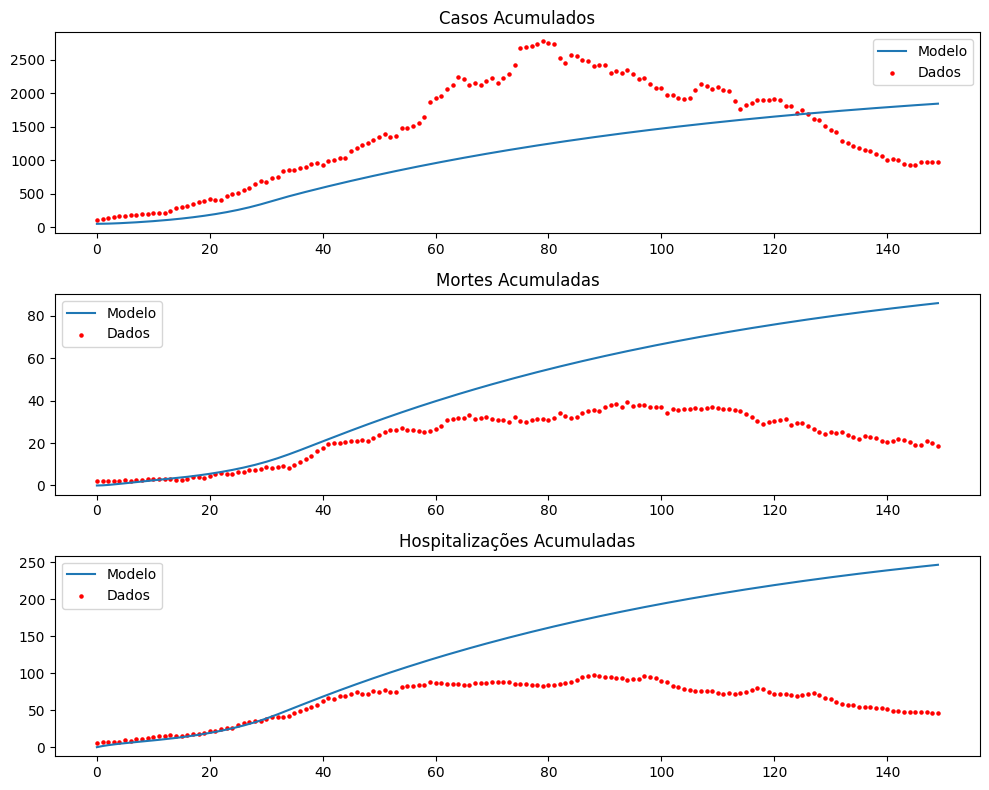

In [75]:
# =============== CÉLULA 7: VISUALIZAÇÃO ===============
if PLOTAR_GRAFICOS:
    print("Plotando resultados...")
    
    # Carrega parâmetros (do fit ou arquivo)
    if FITAR_MODELO:
        theta_plot = theta_max
    else:
        theta_plot = np.loadtxt(SAIDA_PARAMS)
    
    # Roda modelo
    sol = model(theta_plot)
    
    # Plotagem
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    
    if USAR_CASOS:
        cases_cumu = daily_cases_1
        axs[0].plot(sol.y[-4], label='Modelo')
        axs[0].scatter(np.arange(len(cases_cumu)), cases_cumu, 
                      s=5, color='red', label='Dados')
        axs[0].set_title('Casos Acumulados')
    
    if USAR_MORTES:
        death_cumu = daily_death_1
        axs[1].plot(sol.y[-5], label='Modelo')
        axs[1].scatter(np.arange(len(death_cumu)), death_cumu, 
                      s=5, color='red', label='Dados')
        axs[1].set_title('Mortes Acumuladas')
    
    if USAR_HOSP:
        hosp_cumu = daily_hosp_1
        axs[2].plot(sol.y[-3], label='Modelo')
        axs[2].scatter(np.arange(len(hosp_cumu)), hosp_cumu, 
                      s=5, color='red', label='Dados')
        axs[2].set_title('Hospitalizações Acumuladas')
    
    for ax in axs:
        ax.legend()
    plt.tight_layout()
    plt.show()

In [76]:
(daily_death_1)


array([ 2.14285714,  2.14285714,  2.14285714,  2.14285714,  2.14285714,
        2.57142857,  2.28571429,  2.42857143,  2.71428571,  2.85714286,
        3.14285714,  3.        ,  2.85714286,  3.        ,  2.57142857,
        2.71428571,  3.14285714,  3.85714286,  4.        ,  3.71428571,
        4.42857143,  5.28571429,  5.71428571,  5.57142857,  5.42857143,
        6.14285714,  6.42857143,  7.14285714,  7.14285714,  8.        ,
        8.57142857,  8.42857143,  8.57142857,  9.14285714,  8.42857143,
        9.85714286, 11.14285714, 12.71428571, 14.14285714, 16.14285714,
       17.57142857, 19.71428571, 20.14285714, 20.        , 20.42857143,
       21.14285714, 21.14285714, 21.28571429, 21.        , 22.42857143,
       23.85714286, 25.14285714, 26.        , 26.28571429, 27.28571429,
       26.14285714, 26.14285714, 25.71428571, 25.42857143, 25.57142857,
       26.57142857, 27.85714286, 30.71428571, 31.42857143, 31.71428571,
       31.85714286, 33.14285714, 31.57142857, 32.        , 32.42

In [77]:
np.diff(sol.y[-4])

array([ 0.81013815,  2.05012796,  2.90686728,  3.54177642,  4.05678067,
        4.50323825,  4.92725159,  5.33530137,  5.75437781,  6.19037635,
        6.64168156,  7.12146956,  7.63378079,  8.17814608,  8.75573119,
        9.37465729, 10.03778846, 10.74713808, 11.50488192, 12.31334493,
       13.17832447, 14.10618818, 15.10079818, 16.16597288, 17.30553065,
       18.52328991, 19.82306903, 21.21303715, 22.70633428, 24.35617281,
       25.38195926, 24.38353873, 23.54647935, 22.93512668, 22.4172382 ,
       22.00299148, 21.68185151, 21.36271782, 21.06122934, 20.79055789,
       20.5392403 , 20.28219581, 20.02594252, 19.77762162, 19.54437432,
       19.3210272 , 19.09053629, 18.8574918 , 18.62531277, 18.39741824,
       18.17722723, 17.96815878, 17.7717714 , 17.5681817 , 17.35261259,
       17.13082691, 16.90858771, 16.691658  , 16.48580083, 16.29677922,
       16.1303562 , 15.96657402, 15.77187432, 15.56967169, 15.36855116,
       15.176958  , 15.00333745, 14.84116348, 14.66322863, 14.48